# Assignment 4

*Due on November 11th, 2020*

## Group Members

* Shai Slav (Collaborated on both problems)
* Mark Forese (Formatted questions, collaborated on both problems)


In [4]:
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

### Problem 1: What on erf?!

By this time in the semester, you’ve seen a Gaussian a few times. This one should look no different:

$$f(t;\sigma) = \frac{1}{\sqrt{2 \, \pi \sigma^2}}\exp{\left(-\frac{t^2}{2\,\sigma^2}\right)} \;\;\;\; (1)$$

And you might even remember integrating that Gaussian, at least over the entire real line:

$$\int_{-\infty}^{\infty} dt f(t;\sigma) = 2 \int_0^{\infty} f(t;\sigma) = 1 \;\;\;\; (2)$$

But have you ever tried to integrate a Gaussian over a *finite* portion of the real line? No?

Well actually, you have (if only indirectly)! Remember Assignment 2, Problem 3? If you do, then this beast should look familiar:

$$\int_{-x}^{x} dt f(t;\sigma)= 2 \int_0^{x} dt f(t;\sigma) \equiv \text{erf}\left(\frac{x}{\sqrt{2\sigma^2}}\right) \;\;\;\; (3)$$

Let’s have some fun with it.

#### Part A (0.25 points)

Python knows about erf (the “error function”):
```
from scipy import special
print("erf(1) =",special.erf(1))
```

Matlab knows about erf too: ```erf(x)``` Set $\sigma = 1/\sqrt{2}$ in (3) and make a plot of erf(x) for
x $\in [0, 2\sqrt{2}]$. 

(Handy fact: for a Gaussian, the values less than n standard deviations away from the mean account for a fraction erf$\left(\frac{n}{\sqrt{2}}\right)$ of the set.) 

erf(1)  0.8427007929497148


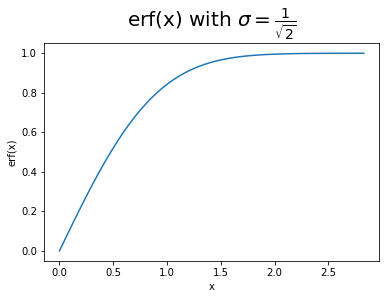

In [9]:
from scipy import special
print('erf(1) ',special.erf(1))

x = np.linspace(0,2*np.sqrt(2),100)
erfs = special.erf(x)

plt.plot(x,erfs)
plt.xlabel('x')
plt.ylabel('erf(x)')

plt.title(r'erf(x) with $\sigma = \frac{1}{\sqrt{2}}$',fontsize = 20)
plt.show()

#### Part B (2 points)

Suppose you weren’t so fortunate as to have erf pre-programmed into python and matlab. You’d have to calculate (3) numerically. And that’s just what you’ll do. Use (1) Monte-Carlo integration with uniform sampling to calculate erf($\sqrt{2}$). Plot the error vs. the number of random samples N $\in [1, 10^6]$ used in the integration and show that it converges as $\sim 1 / \sqrt{N}$. A reminder of the algorith: for N samples $x_i \in [a,b]$,

$$\mathcal{I} = \int_a^b dx f(x) \approx \mathcal{I} \equiv (b - a)\langle f \rangle \pm (b - a) \sqrt{\frac{\langle f^2 \rangle - \langle f \rangle^2}{N}}\:\;\;\;\;\text{ (4) }$$

where:

$$\langle f \rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} f(x_i)$$

and,

$$\langle f^2 \rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} f^2(x_i)$$

Note that the $\pm$ error term here is only an estimate - there is no guarantee that the error is distributed as a Gaussian. 

Indeed, **plot $| \mathcal{I} - \mathcal{I}(N) | \, / \, \mathcal{I}$ (i.e., the percent difference between the “true” answer from ```special.erf(x)``` and your numerical answer) versus N** and you’ll see that the error term in (4) gets accurate only once $N \gg 1$. (You can only do this comparison if you know the exact answer; but if you did, then you wouldn’t be doing numerical integration in the first place! That means that the error estimate in (4) is usually all you have on which to rely.)

In [53]:
def f(t, sigma = 1/np.sqrt(2)):
    return 2 / (np.sqrt(2*np.pi*sigma**2)) *np.exp(-t**2/(2*sigma**2))


def monte_carlo(x,num_samples):
    '''generates an estimate for erf(x) using monte carlo integration'''
    rand_xs = x*np.random.rand(num_samples)
    
    evals = np.zeros((rand_xs.shape))
    
    for i in range(num_samples):
        x = rand_xs[i]
        evals[i] = f(x)
        
    est = (x/num_samples)*sum(evals)
    
    return est
    
    
Ns = np.array([1,10,100,1e3,1e4,1e5,1e6])
estimates = np.zeros(Ns.size)
errors = np.zeros(Ns.size)

for i in range(len(Ns)):
    print(i)
    N = int(Ns[i])
    print(N)
    estimates[i] = monte_carlo(2*np.sqrt(2),N)

0
1
1
10
2
100
3
1000
4
10000
5
100000
6
1000000


In [54]:
print(estimates)
print(special.erf(2*np.sqrt(2)))

[0.00365058 0.53706682 0.19083514 0.53089943 0.9470467  0.599401
 0.35526333]
0.9999366575163338


#### Part C (1.5 points)

Doing uniform sampling of a peaked distribution (such as a Gaussian) is incredibly inefficient. Most of the time, you’re taking samples from pieces of the integrand that hardly contribute to the integral. There must be a better way, and there is: “importance sampling”. I mentioned this algorithm in class, but review it here to be self-contained.

The idea is to write:

$$\mathcal{I} = \int_a^b dx g(x) \frac{f(x)}{g(x)} = \int_a^b dG(x) \frac{f(x)}{g(x)} = \int_{G(a)}^{G(b)} dr \frac{f(G^{-1}(r))}{g(G^{-1}(r))}$$

with:

$$G(x) \equiv \int_a^x dx' g(x')$$

for some wisely chosen function g(x) > 0, and then sample not f uniformly but rather f/g nonuniformly, the function g dictating how do to the nonuniform sampling. (Es- sentially, you’re asking what is the expectation value of f/g given the probability distribution g.) How does one choose g? Well, you’d want to sample the integrand with a higher density of points in the region(s) where the integrand is large. One can prove that setting g = $|f|\, / \int dx|f|$ minimixes the variance (and thus the error for a given N). The issue is that drawing random samples from a |f|-distributed probability distribution function is basically what we were trying to do in the first place.

So, instead try the following. We just want something that is close to being proportional to |f| and can be analytically integrated. Set $g(x) \propto e^{-\sqrt{2}x}$, whcih decreases by a factor of $e^2$ from x = 0 to x = $\sqrt{2}$ (jsut as $e^{-x^2}$ does) Normalize g(x):

$$\int_0^{\sqrt{2}} dx e^{-\sqrt{2}x} = \frac{1}{\sqrt{2}} (1 - e^{-2}) \Longrightarrow g(x) \frac{\sqrt{2}e^{-\sqrt{2}x}}{1 - e^{-2}}$$

Then

$$G(x) = \int_0^x dx' \frac{\sqrt{2}e^{-\sqrt{2}x'}}{1-e^2} = \frac{1 - e^{-\sqrt{2}x}}{1 - e^{-2}}$$

The inverse is readily computed:

$$G^{-1}(r) = -\frac{1}{\sqrt{2}} \ln \left[1 - r(1 - e^{-2})\right]$$

Now you just draw uniform random numbers $r_i \in [G(0),G(\sqrt{2}]$ = [0,1] from (5) and use these in

$$\mathcal{I} = \int_{G(a)}^{G(b)} dr \frac{f(G^{-1}(r))}{g(G^{-1}(r))} \approx \mathcal{I} \equiv \left\langle\frac{f}{g}\right\rangle \pm \sqrt{\frac{\langle\frac{f^2}{g^2}\rangle - \langle\frac{f}{g}\rangle^2}{N}}$$

where

$$\left\langle\frac{f}{g}\right\rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} \frac{f(r_i)}{g(r_i)}$$

and,

$$\left\langle\frac{f^2}{g^2}\right\rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} \frac{f^2(r_i)}{g^2(r_i)}$$

Write a program to do so, and compare with your results from part (b). In particular, how many fewer iterations were required using importance sampling with $g(x) \propto \exp{(-\sqrt{2}x)}$ to achieve the same error found in part (b)? Neat, huh?

#### Part D (2 points)

Next, write a program to compute erf($\sqrt{2}$) using both the trapezoidal rule:

$$\int_{x_0}^{x_{N-1}} dx f(x) = \frac{h}{2} [ f(x_0) + 2 f(x_1) + 2 f(x_2) + ... + 2 f(x_{N-2}) + f(x_{N-1})] + \mathcal{O}(h^3 f'')$$

which uses a piecewise linear approximation for the function, and Simpson's rule:

$$\int_{x_0}^{x_{N-1}} dx f(x) = \frac{h}{3} [ f(x_0) + 4 f(x_1) + 2 f(x_2) + 4f(x_3)+... + 2f(x_{N-3})+ 4 f(x_{N-2}) + f(x_{N-1})] + \mathcal{O}(h^5 f'''')$$

which uses a piecewise-parabolic approximation for the function. In both formulas, N is the number of points sampled and h ≡ (b − a)/(N − 1) is the uniform step size taken between the integration limits a and b. (Note that N − 1 is the number of divisions.) For Simpson’s rule to work in the above form, N must be odd and ≥ 5

For each approximation, plot the error as a function of N = 5...99 and compare to the expected convergence rates. What step size h gives you roughly the same accuracy as the Monte-Carlo integration from part (b) after 106 uniformly distributed random
samples?

#### Part E (0.25 points)

Now the easy way out. In python, type the following:

```
import numpy as np
import scipy.integrate as integ

def f(x):
    return 2/np.sqrt(np.pi)*np.exp(-x*x)
    
integ.quad(f,0,np.sqrt(2))
```
Voila. This should return the result plus an estimate of the error. Write down this answer so that we know you did this part (free points!), and then visit https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html.
(You can even do integ.quad(f,0,Inf) with this function!)

In [2]:
import numpy as np
import scipy.integrate as integ

def f(x):
    return 2/np.sqrt(np.pi)*np.exp(-x*x)

integ.quad(f,0,np.sqrt(2))

(0.9544997361036415, 1.0597075840208986e-14)

### Problem 2: Simulating a planetary system.

Something that astronomers sometimes do to sanity check their fit of exoplanet data is use an N-body integrator to solve

$$\frac{d\mathbf{r}_i}{dt} = \mathbf{v}_i \text{ and } \frac{d\mathbf{v}_i}{dt} = \sum_{i\neq j}^{N} \frac{G m_j \mathbf{r}_{ij}}{r_{ij}^3} , \text{ where } \mathbf{r}_{ij} \equiv \mathbf{r}_j = \mathbf{r}_i$$

and check whether or not their fit parameters result in a dynamically stable system. In this problem, I’ll teach you how to write your own two-body integrator, which we’ll use to continue HW03’s study of the exoplanetary system HAT-P-21. Start by visiting

http://openexoplanetcatalogue.com/planet/HAT-P-21%20b/

and fetching the planet mass $m_p$, the orbital eccentricity e, the semi-major axis a, and the host star’s mass $m_s$. Recalling footnote 3 from HW03, you’d be best served by measuring time in yr, length in au, and mass in $M_\odot$ = 1047.592421 $M_J$, where $M_J$ is the mass of Jupiter.
If you do so, then Kepler’s third law gives a rather simple gravitational constant G = $(2\pi)^2$ .

#### Part A (1.25 Points)

Pretty much the worst thing you can do is use forward-Euler to solve the two-body problem. You can find some python code that I wrote at

https://www.astro.princeton.edu/~kunz/Site/AST303/euler-Nbody.py

that does forward-Euler for an arbitrary number of bodies.
insert the values for $m_p$, e, a, and $m_s$ where indicated. Then run the code and make plots of (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. (The latter should be a ```semilogy``` plot. Don’t forget to label your axes and specify their units.) Describe these plots in words.

#### Part B (1.25 Points)

Perhaps the next best thing to use is second-order Runge-Kutta (RK2). You can find some python code that I wrote at

https://www.astro.princeton.edu/~kunz/Site/AST303/rk2-Nbody.py

that does RK2 for an arbitrary number of bodies. Insert the values for $m_p$, e, a, and $m_s$ where indicated. Then run the code and make plots of (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. (The latter should be a ```semilogy``` plot. Don’t forget to label your axes and specify their units.) Describe these plots in words.

#### Part C (4 Points)

This is a problem set. So then why am I writing your code for you?! Well, because you are now going to use that code as a template to write your own. Upgrade the RK2 code to a fourth-order Runge-Kutta (RK4) code. Use it to integrate the same two-body problem as in parts (a) and (b)—same timestep h, same total integration time tf, same masses and initial conditions—and make labelled plots of (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. This should look much better than the RK2 solution. . . in fact, it should look ∼O(h2) better. Show this explicitly by comparing |$\mathcal{E}(t_f)$ − $\mathcal{E}$(0)| for RK2 and RK4.

#### Part D (4 Points)

Write a python routine to integrate the two-body system using the leapfrog method. As explained in class, you need to first obtain one of the variables at the half-step to begin the leapfrog integration. It’s your choice which one to offset. If you choose to offset **x**<sub>n</sub> to **x**<sub>n+ 1/2</sub>, then the velocity is updated via $\mathbf{v}_{n+1} = \mathbf{v}_n + \Delta t \; \mathbf{a}(\mathbf{x}_{n+ 1/2})$. If you instead choose to offset**v**<sub>n</sub> to **v**<sub>n+ 1/2</sub> then the position is updated via $\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \; \mathbf{v}_{n+1/2}$. Whichever version you choose, use my RK2 code to obtain the initial value of the offset variable by integrating (7) for a time h/2. Once you have this, leapfrog takes over...

Once finished, plot (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. If you’ve done it correctly, the error in the energy of the system will not grow in time! But recall the discussion in class: To compute $\mathcal{E}(t)$, the velocities and positions are required at the same time, which is not a natural state of affairs during a leapfrog integration. One way to do this is to update the positions over a time interval h/2 first to make it cotemporal with the velocity, then compute $\mathcal{E}$, a leapfrog where one of the people leapfrogging (**r**) pauses mid-air over the back of the other (**v**), performs a calculation ($\mathcal{E}$), and then keeps going. You can achieve this via the drift-kick-drift or kick-drift-kick formulations of the leapfrog method.

#### Part E (0.5 Points)

Re-run your leapfrog integrator but with h = $10^{-4}$ until $t_f = 2^{15}h$ (instead of the original h = $10^{-5}$ until $t_f = 2^{17}h$) Examine the orbit and the total energy. You’ll see that, while the total energy is still conserved, the orbit is precessing. Two-body Keplerian orbits should not precess! What’s going on? (Hint: Re-run your RK4 integrator with $h = 10^{-4}$ and $t_f = 2^{15}$ and examine the orbit. What's different?)

Because the code template I gave you works for an arbitrary number of bodies (as should your code), you could play a bit with (N > 2)-body systems if you’d like. Here are the initial conditions for a fun system only 15 light-years away:

https://www.astro.princeton.edu/~kunz/Site/AST303/GJ876_initial_conditions.py

### Problem 3: FFT'int a planetary system (3 Points)

Now that you have an orbit integrated with constant timestep, you can analyze its time series using an FFT and check that it has the same period P as declared on the exoplanet catalogue website. 

Take the time series $v_x(t)$ from Problem 2(d) and FFT it. 

Use this to plot the power spectrum of the signal versus frequency f. 

Does it peak near the period P = 1/f that you found on the website? 

Identify any numerical artifacts or higher-order peaks that you see and comment on their origin. 

Also calculate the Nyquist frequency of the data.

